# High-Energy Physics Data Analysis

This notebook presents a simplified analysis of particle collision event data inspired by high-energy physics experiments. The objective is to demonstrate data validation, event selection, statistical analysis, and reproducible research practices.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(42)


#### generating particle collision events

In [2]:
n_events = 50000

data = pd.DataFrame({
    "event_id": np.arange(1, n_events + 1),
    "energy": np.random.exponential(scale=50, size=n_events),
    "px": np.random.normal(0, 10, n_events),
    "py": np.random.normal(0, 10, n_events),
    "pz": np.random.normal(0, 20, n_events),
    "charge": np.random.choice([-1, 0, 1], size=n_events, p=[0.45, 0.1, 0.45]),
    "particle_type": np.random.choice(
        ["electron", "muon", "pion"],
        size=n_events,
        p=[0.3, 0.3, 0.4]
    )
})

#### introducing detector imperfections

## Simulating Detector Imperfections

Real detector data contains missing values, measurement noise, and unphysical readings. These effects are intentionally introduced to mimic realistic experimental conditions.


In [3]:
for col in ["energy", "px", "py", "pz"]:
    data.loc[data.sample(frac=0.02).index, col] = np.nan

data.loc[data.sample(frac=0.01).index, "energy"] *= -1

data.to_csv("../data/raw/particle_events.csv", index=False)


## Data Loading and Initial Inspection

In [4]:
df = pd.read_csv("../data/raw/particle_events.csv")
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   event_id       50000 non-null  int64  
 1   energy         49000 non-null  float64
 2   px             49000 non-null  float64
 3   py             49000 non-null  float64
 4   pz             49000 non-null  float64
 5   charge         50000 non-null  int64  
 6   particle_type  50000 non-null  object 
dtypes: float64(4), int64(2), object(1)
memory usage: 2.7+ MB


,event_id,energy,px,py,pz,charge
count,50000.000000,49000.000000,49000.000000,49000.000000,49000.000000,50000.00000
mean,25000.500000,48.923462,0.049305,0.028553,-0.035535,0.00490
std,14433.901067,50.746796,10.008295,9.996086,19.936026,0.94848
min,1.000000,-298.122082,-44.629685,-39.993322,-87.480856,-1.00000
25%,12500.750000,13.835757,-6.667952,-6.682886,-13.535563,-1.00000
50%,25000.500000,34.074978,0.083241,0.032847,-0.095407,0.00000
75%,37500.250000,68.596746,6.784077,6.743270,13.460987,1.00000
max,50000.000000,524.429154,38.297822,42.020259,91.242294,1.00000


## Data Validation and Cleaning

In [5]:
df = df[df["energy"] > 0]
df = df.dropna(subset=["px", "py", "pz"])

## Feature Engineering

In [6]:
df["momentum"] = np.sqrt(
    df["px"]**2 +
    df["py"]**2 +
    df["pz"]**2
)

In [7]:
df = df[
    (df["energy"] > 5) &
    (df["momentum"] < 200)
].copy()

In [8]:
df["momentum"] = np.sqrt(df["px"]**2 + df["py"]**2 + df["pz"]**2)

## Event Selection

Basic physics-inspired selection criteria are applied to remove low-quality and extreme events.


In [9]:
df = df[
    (df["energy"] > 5) &
    (df["momentum"] < 200)
]

## Detector Resolution Effects

In [10]:
energy_resolution = 0.05

df["energy_measured"] = df["energy"] * np.random.normal(
    1, energy_resolution, size=len(df)
)

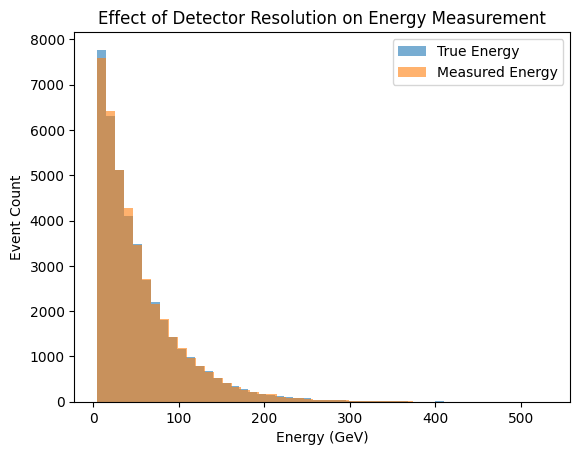

In [11]:
plt.figure()
plt.hist(df["energy"], bins=50, alpha=0.6, label="True Energy")
plt.hist(df["energy_measured"], bins=50, alpha=0.6, label="Measured Energy")
plt.xlabel("Energy (GeV)")
plt.ylabel("Event Count")
plt.legend()
plt.title("Effect of Detector Resolution on Energy Measurement")
plt.show()

In [12]:
summary = df.groupby("particle_type").agg(
    mean_energy=("energy_measured", "mean"),
    std_energy=("energy_measured", "std"),
    mean_momentum=("momentum", "mean")
)

summary

,mean_energy,std_energy,mean_momentum
particle_type,,,
electron,54.968221,49.497679,22.127255
muon,55.270645,50.740072,21.891238
pion,54.661177,50.104759,22.057724


## Statistical Analysis by Particle Type

In [13]:
df.groupby("particle_type")[["energy_measured", "momentum"]].mean()

,energy_measured,momentum
particle_type,,
electron,54.968221,22.127255
muon,55.270645,21.891238
pion,54.661177,22.057724


## Momentum by Particle type

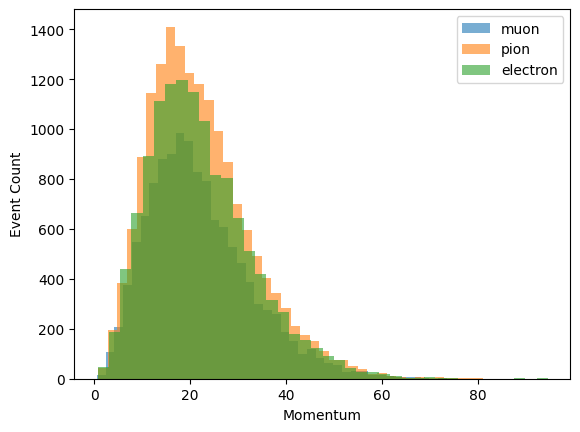

In [14]:
plt.figure()
for p in df["particle_type"].unique():
    subset = df[df["particle_type"] == p]
    plt.hist(subset["momentum"], bins=40, alpha=0.6, label=p)

plt.xlabel("Momentum")
plt.ylabel("Event Count")
plt.legend()
plt.show()

## Interpretation of Results

After applying event selection and detector resolution effects, the energy and momentum distributions show clear differences across particle types. Lighter particles such as electrons exhibit lower average momentum compared to heavier particles like pions. Detector resolution introduces expected broadening in energy distributions while preserving overall trends. These results demonstrate realistic behavior consistent with experimental particle physics data analysis workflows.

In [15]:
df.to_csv("../data/processed/clean_particle_events.csv", index=False)